<a href="https://colab.research.google.com/github/jbkim900/Jeongbeom-kim/blob/main/lightGBM2_2025_01_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **🏠 부동산 실거래가 Baseline code**
> 부동산 실거래가 예측 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 RandomForest를 활용해 ML 방법론들을 실제 대회에 적용해보도록 하겠습니다.
> 강의는 google colab으로 실행하였기에 아래의 베이스라인 코드와는 일부 차이가 있을 수 있습니다.

## Contents
- Library Import
- Data Load
- Data Preprocessing
- Feature Engineering
- Model Training
- Inference
- Output File Save


## 1. Library Import
- 필요한 라이브러리를 불러옵니다.

In [1]:
!pip install eli5==0.13.0

# 한글 폰트 사용을 위한 라이브러리입니다.
!apt-get install -y fonts-nanum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107721 sha256=5c8455288e854dc45f40315a44562e35adec2160e103c51034471a69755026ad
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (6,246 kB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 123634 files and directories currently installed.)
Preparing to 

In [2]:
!pip install scikit-learn==1.0.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 29.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.29.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.0.2 which is incompatible.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.0.2 which is incompatible.


In [3]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

## 2. Data Load

#### 2.1. 데이터 로드

In [5]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
train_path = '/content/train.csv'
test_path  = '/content/test.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

In [6]:
# Train data와 Test data shape은 아래와 같습니다.
print('Train data shape : ', dt.shape, 'Test data shape : ', dt_test.shape)

Train data shape :  (1118822, 52) Test data shape :  (9272, 51)


In [7]:
# Train과 Test data를 살펴보겠습니다.
display(dt.head(1))
display(dt_test.head(1))      # 부동산 실거래가(=Target) column이 제외된 모습입니다.

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000


,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,202307,26,5,1987,...,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0


In [8]:
print(dt.dtypes)

시군구                        object
번지                         object
본번                        float64
부번                        float64
아파트명                       object
전용면적(㎡)                   float64
계약년월                        int64
계약일                         int64
층                           int64
건축년도                        int64
도로명                        object
해제사유발생일                   float64
등기신청일자                     object
거래유형                       object
중개사소재지                     object
k-단지분류(아파트,주상복합등등)         object
k-전화번호                     object
k-팩스번호                     object
단지소개기존clob                float64
k-세대타입(분양형태)               object
k-관리방식                     object
k-복도유형                     object
k-난방방식                     object
k-전체동수                    float64
k-전체세대수                   float64
k-건설사(시공사)                 object
k-시행사                      object
k-사용검사일-사용승인일              object
k-연면적                     float64
k-주거전용면적      

In [9]:
print(dt.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118822 entries, 0 to 1118821
Data columns (total 52 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1118822 non-null  object 
 1   번지                      1118597 non-null  object 
 2   본번                      1118747 non-null  float64
 3   부번                      1118747 non-null  float64
 4   아파트명                    1116696 non-null  object 
 5   전용면적(㎡)                 1118822 non-null  float64
 6   계약년월                    1118822 non-null  int64  
 7   계약일                     1118822 non-null  int64  
 8   층                       1118822 non-null  int64  
 9   건축년도                    1118822 non-null  int64  
 10  도로명                     1118822 non-null  object 
 11  해제사유발생일                 5983 non-null     float64
 12  등기신청일자                  1118822 non-null  object 
 13  거래유형                    1118822 non-null  object 
 14  중개

## 3. Data Preprocessing

- 모델링 전에 데이터 내 결측치, 이상치 등을 제거하고 범주형과 연속형 변수를 살펴보도록 하겠습니다!
- 먼저, 용이한 전처리를 위해 train과 test data를 합친 하나의 데이터로 진행하도록 하겠습니다.

In [10]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
dt['is_test'] = 0
dt_test['is_test'] = 1
concat = pd.concat([dt, dt_test])     # 하나의 데이터로 만들어줍니다.

In [11]:
concat['is_test'].value_counts()      # train과 test data가 하나로 합쳐진 것을 확인할 수 있습니다.

,count
is_test,
0,1118822
1,9272


In [12]:
# 칼럼 이름을 쉽게 바꿔주겠습니다. 다른 칼럼도 사용에 따라 바꿔주셔도 됩니다!
concat = concat.rename(columns={'전용면적(㎡)':'전용면적'})

### 3.1. 결측치 탐색 및 보간
- 결측치를 처리할 때 많이 쓰는 방법은 삭제(Deletion)과 대체(Imputation) 입니다.
- 본 Baseline에서는 결측치가 90% 이상을 차지하는 변수의 결측치는 제거하고, 나머지 결측치는 대체하도록 하겠습니다.
  - 연속형 변수의 경우에는 선형보간(Linear interpolation)으로 대체하겠습니다.
  - 범주형 변수의 경우에는 'NULL' 이라는 임의의 범주로 대체해주도록 하겠습니다.

- 참고 ✅
  - 선형보간(Linear interpolation)이란 두 점의 값이 주어졌을 때 **그 사이의 값**을 추정하기 위해 직선 거리에 따라 선형적으로 계산하는 방법입니다.
  - 아래 두개의 붉은 점 사이에 ($x$, $y$) 값을 추정하기 위해, 해당 점이 두 붉은 점을 이은 선형적인 선분에 있다고 가정하고, 단순 비례식으로 ($x$, $y$)를 추정해 보간하는 방법입니다.
  - [참고자료](https://ko.wikipedia.org/wiki/%EC%84%A0%ED%98%95_%EB%B3%B4%EA%B0%84%EB%B2%95#:~:text=%EC%84%A0%ED%98%95%20%EB%B3%B4%EA%B0%84%EB%B2%95(%E7%B7%9A%E5%9E%8B%E8%A3%9C%E9%96%93%E6%B3%95,%EC%9C%BC%EB%A1%9C%20%EA%B3%84%EC%82%B0%ED%95%98%EB%8A%94%20%EB%B0%A9%EB%B2%95%EC%9D%B4%EB%8B%A4.)


> 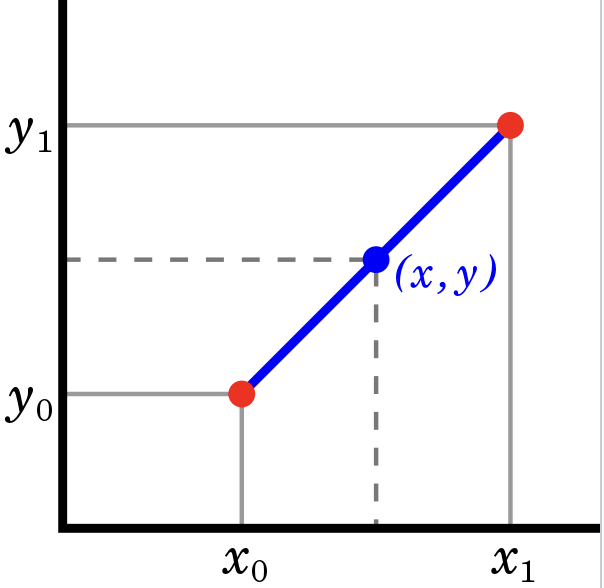

In [13]:
# 실제로 결측치라고 표시는 안되어있지만 아무 의미도 갖지 않는 element들이 아래와 같이 존재합니다.
# 아래 3가지의 경우 모두 아무 의미도 갖지 않는 element가 포함되어 있습니다.
display(concat['등기신청일자'].value_counts())

,count
등기신청일자,
,1111271
20230630,585
20230831,496
20230428,394
20230731,374
...,...
20230105,3
20230125,3
20230109,1


In [14]:
display(concat['거래유형'].value_counts())

,count
거래유형,
-,1086451
중개거래,38123
직거래,3520


In [15]:
display(concat['중개사소재지'].value_counts())

,count
중개사소재지,
-,1090013
서울 노원구,2627
서울 송파구,2540
서울 강남구,2508
서울 강동구,2038
...,...
"서울 강북구, 서울 양천구",1
"경기 남양주시, 경기 성남수정구",1
"서울 송파구, 인천 계양구",1


In [16]:
# 위 처럼 아무 의미도 갖지 않는 칼럼은 결측치와 같은 역할을 하므로, np.nan으로 채워 결측치로 인식되도록 합니다.
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)

In [17]:
# EDA에 앞서 결측치를 확인해보겠습니다.
concat.isnull().sum()

,0
시군구,0
번지,227
본번,75
부번,75
아파트명,2136
전용면적,0
계약년월,0
계약일,0
층,0
건축년도,0


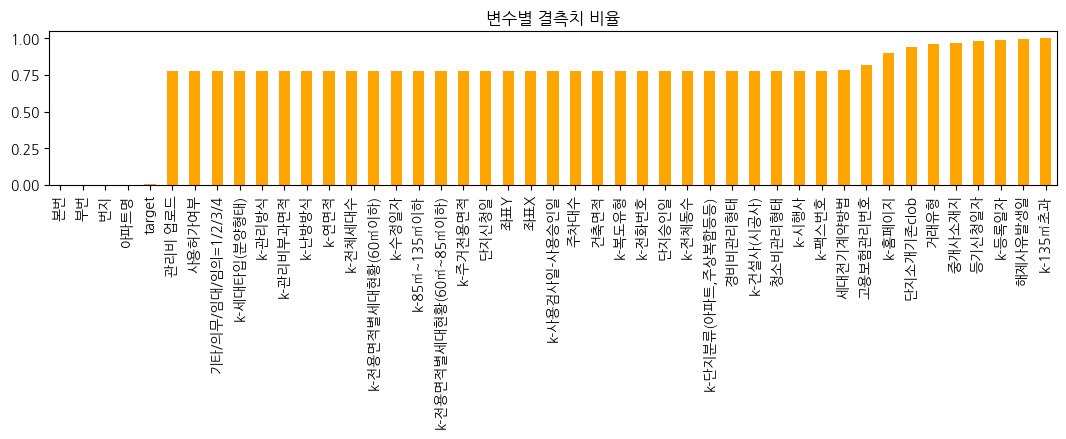

In [18]:
# 변수별 결측치의 비율을 plot으로 그려보면 아래와 같습니다.
fig = plt.figure(figsize=(13, 2))
missing = concat.isnull().sum() / concat.shape[0]
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()

### 결측치 80만개 이상 변수 삭제

In [19]:
# Null값이 80만개 이상인 칼럼은 삭제해보도록 하겠습니다.
print('* 결측치가 80만개 이하인 변수들 :', list(concat.columns[concat.isnull().sum() <= 800000]))     # 남겨질 변수들은 아래와 같습니다.
print('* 결측치가 80만개 이상인 변수들 :', list(concat.columns[concat.isnull().sum() >= 800000]))

* 결측치가 80만개 이하인 변수들 : ['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명', 'target', 'is_test']
* 결측치가 80만개 이상인 변수들 : ['해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일']


In [20]:
# 위에서 결측치가 80만개 이하인 변수 + 좌표X,Y만 골라 새로운 concat_select 객체로 저장해줍니다.
selected = list(concat.columns[concat.isnull().sum() <= 800000])
selected += ['좌표X', '좌표Y']
concat_select = concat[selected]

In [21]:
concat_select.isnull().sum()     # 결측치가 100만개 초과인 칼럼이 제거된 모습은 아래와 같습니다.
# target변수는 test dataset 개수만큼(9272) 결측치가 존재함을 확인할 수 있습니다.

,0
시군구,0
번지,227
본번,75
부번,75
아파트명,2136
전용면적,0
계약년월,0
계약일,0
층,0
건축년도,0


### 도로명 데이터 오류 해결
도로명에 숫자만 있거나 --로와 같이 문자만 있는 데이터 오류 존재하기 때문에 다음과 같은 방식을 통해 해결해줍니다.
1. 잘못된 도로명 식별:
   - 문자만 있는 도로명 필터링 (str.isalpha())
   - 숫자만 있는 도로명 필터링 (str.isnumeric())

2. 올바른 도로명 찾기:
   - 같은 아파트명을 가진 데이터 중에서
   - 문자와 숫자가 모두 포함된 도로명을 찾음
   - 이를 올바른 도로명으로 간주

3. 수정 작업:
   - 잘못된 도로명이 발견되면
   - 같은 아파트명의 올바른 도로명으로 교체

In [22]:
# 비어있는 값 제거
concat_select['도로명'] = concat_select['도로명'].fillna('').str.strip()

# 문자만 있는 데이터 추출 (공백 제외)
only_letters = concat_select[concat_select['도로명'].str.match(r'^[가-힣\s]+$', na=False) & (concat_select['도로명'] != '')]

# 숫자만 있는 데이터 추출 (공백 제외)
only_numbers = concat_select[concat_select['도로명'].str.match(r'^[0-9\s-]+$', na=False) & (concat_select['도로명'] != '')]

# 결과 확인
print("문자만 있는 데이터:")
print(only_letters)

print("\n숫자만 있는 데이터:")
print(only_numbers)

문자만 있는 데이터:
                   시군구   번지     본번   부번     아파트명    전용면적    계약년월  계약일   층  \
95372    서울특별시 강남구 개포동  141  141.0  0.0  개포주공1단지   35.64  201110    5   1   
95373    서울특별시 강남구 개포동  141  141.0  0.0  개포주공1단지   58.08  201110    5   4   
95374    서울특별시 강남구 개포동  141  141.0  0.0  개포주공1단지   58.08  201110    6   4   
95375    서울특별시 강남구 개포동  141  141.0  0.0  개포주공1단지   58.08  201110    7   2   
95377    서울특별시 강남구 개포동  141  141.0  0.0  개포주공1단지   58.08  201110    7   4   
...                ...  ...    ...  ...      ...     ...     ...  ...  ..   
1110418   서울특별시 양천구 목동  925  925.0  0.0  목동신시가지7  101.20  200707   25   4   
1110420   서울특별시 양천구 목동  925  925.0  0.0  목동신시가지7   66.60  200708   10  15   
1110421   서울특별시 양천구 목동  925  925.0  0.0  목동신시가지7  101.20  200708   15  14   
1110424   서울특별시 양천구 목동  925  925.0  0.0  목동신시가지7   66.60  200709   29   7   
1110425   서울특별시 양천구 목동  925  925.0  0.0  목동신시가지7   64.40  200709   30   1   

         건축년도  도로명    target  is_test         좌표X        좌표Y  


In [23]:
# 문자만 있는 데이터와 전체 데이터를 연결해 필터링
only_letters_apartments = concat_select.loc[concat_select['도로명'].isin(only_letters['도로명']), ['도로명','아파트명', '시군구', '번지']]

# 결과 출력
print(only_letters_apartments)

# 숫자만 있는 데이터와 전체 데이터를 연결해 필터링
only_numbers_apartments = concat_select.loc[dt['도로명'].isin(only_numbers['도로명']), ['도로명','아파트명', '시군구', '번지']]

# 결과 출력
print(only_numbers_apartments)

         도로명     아파트명            시군구   번지
95372    개포로  개포주공1단지  서울특별시 강남구 개포동  141
95373    개포로  개포주공1단지  서울특별시 강남구 개포동  141
95374    개포로  개포주공1단지  서울특별시 강남구 개포동  141
95375    개포로  개포주공1단지  서울특별시 강남구 개포동  141
95377    개포로  개포주공1단지  서울특별시 강남구 개포동  141
...      ...      ...            ...  ...
1110418  목동로  목동신시가지7   서울특별시 양천구 목동  925
1110420  목동로  목동신시가지7   서울특별시 양천구 목동  925
1110421  목동로  목동신시가지7   서울특별시 양천구 목동  925
1110424  목동로  목동신시가지7   서울특별시 양천구 목동  925
1110425  목동로  목동신시가지7   서울특별시 양천구 목동  925

[1001 rows x 4 columns]
Empty DataFrame
Columns: [도로명, 아파트명, 시군구, 번지]
Index: []


In [24]:
# 숫자만 포함된 도로명과 문자만 포함된 도로명을 필터링
only_letters_roadnames = concat_select[concat_select['도로명'].str.isalpha()]  # 문자만 포함된 도로명
only_numbers_roadnames = concat_select[concat_select['도로명'].str.isnumeric()]  # 숫자만 포함된 도로명

# 잘못된 도로명 데이터를 찾기 위한 조건:
# 1. 도로명이 문자만 있거나,
# 2. 도로명이 숫자만 있거나,
# 3. 도로명이 하이픈 포함된 숫자만 있는 경우

# 각 아파트명별로 올바른 도로명을 찾기 위해 문자+숫자 형태의 도로명이 있는 데이터 필터링
correct_roadnames = concat_select[~concat_select['도로명'].str.isalpha() & ~concat_select['도로명'].str.replace('-', '').str.isnumeric()]

# 아파트명별로 올바른 도로명을 찾기 (문자+숫자 형태)
roadname_mapping = correct_roadnames.groupby('아파트명')['도로명'].agg(lambda x: x.mode()[0]).to_dict()

# 잘못된 도로명 데이터를 찾아서 정확한 도로명으로 수정
def correct_roadname(row):
    # 도로명이 문자만 있거나, 숫자만 있거나, 하이픈 포함 숫자인 경우에만 교체
    if isinstance(row['도로명'], str):
        # 문자만 있거나, 숫자만 있거나, 하이픈 포함된 숫자만 있는 경우
        if row['도로명'].isalpha() or row['도로명'].replace('-', '').isnumeric():
            # 아파트명에 해당하는 올바른 도로명으로 교체
            return roadname_mapping.get(row['아파트명'], row['도로명'])
    return row['도로명']

# '도로명' 수정
concat_select['도로명'] = concat_select.apply(correct_roadname, axis=1)

# 문자만 있는 데이터와 전체 데이터를 연결해 필터링
only_letters_apartments = concat_select.loc[concat_select['도로명'].isin(only_letters['도로명']), ['도로명','아파트명', '시군구', '번지']]

# 결과 출력
print(only_letters_apartments)

# 숫자만 있는 데이터와 전체 데이터를 연결해 필터링
only_numbers_apartments = concat_select.loc[concat_select['도로명'].isin(only_numbers['도로명']), ['도로명','아파트명', '시군구', '번지']]

# 결과 출력
print(only_numbers_apartments)

Empty DataFrame
Columns: [도로명, 아파트명, 시군구, 번지]
Index: []
Empty DataFrame
Columns: [도로명, 아파트명, 시군구, 번지]
Index: []


In [25]:
concat_select.isnull().sum()

,0
시군구,0
번지,227
본번,75
부번,75
아파트명,2136
전용면적,0
계약년월,0
계약일,0
층,0
건축년도,0


## 좌표 X, Y 결측치 대체

### 서울시 공동주택 아파트 정보를 사용하여 좌표 X,Y의 결측치를 채워줍니다.

In [26]:
# # 결측치 대체를 위해 서울시 공동주택 아파트 정보 load (https://data.seoul.go.kr/dataList/OA-15818/A/1/datasetView.do )
# apt_path = '/data/ephemeral/home/data/apt.csv'
# df_apt = pd.read_csv(apt_path, encoding='cp949')

# # '도로명주소'를 기준으로 df_train의 결측치 대체 ('아파트명'은 같은 아파트임에도 서로 일치하지 않는 항목이 많아서)
# df_apt['도로명주소'] = df_apt['주소(도로명)'] + ' ' + df_apt['주소(도로상세주소)']
# df_apt_unique = df_apt.drop_duplicates(subset='도로명주소')

# concat_select['좌표X'] = concat_select['좌표X'].fillna(concat_select['도로명'].map(df_apt_unique.set_index('도로명주소')['좌표X'])).astype('float')
# concat_select['좌표Y'] = concat_select['좌표Y'].fillna(concat_select['도로명'].map(df_apt_unique.set_index('도로명주소')['좌표Y']))

# concat_select.isnull().sum()

### geopy 모듈을 사용해서 좌표X,Y의 결측치를 채워줍니다.
처음부터 결측치를 채우는데 geopy를 이용하지 않은 이유는 좌표 추출 속도가 느려서 데이터 크기가 클 경우 문제가 될 수 있기 때문입니다.

In [27]:
# # 서울특별시 00구 00로 --- 형식의 주소를 만들어주기 위해 addr 컬럼을 만들어 넣어줍니다.
# def get_gu(addr):
#     idx = addr.find('구')
#     return addr[:idx+1]

# concat_select['시구'] = concat_select['시군구'].apply(get_gu)

# concat_select['addr'] = concat_select['시구'] + ' ' + concat_select['도로명']

In [28]:
# %pip install geopy

In [29]:
# # 시간 단축을 위해 좌표가 결측치인 도로명 주소 중 고유한 주소만 추출해서 찾아줍니다.
# # 2시간 44분정도의 시간이 소요되어 주석처리
# from geopy.geocoders import Nominatim
# from tqdm import tqdm
# import time

# # Geocoder 설정
# geo_local = Nominatim(user_agent="South Korea")

# # Geocoding 함수
# def geocoding(address):
#     try:
#         location = geo_local.geocode(address)
#         if location:
#             return location.latitude, location.longitude
#         else:
#             return None, None
#     except Exception as e:
#         print(f"Error with address {address}: {e}")
#         return None, None

# # 1. 결측치가 있는 도로명 주소만 추출 (고유한 주소만)
# unique_addresses = (
#     concat_select.loc[
#         concat_select['좌표X'].isna() & concat_select['좌표Y'].isna(),
#         '도로명',
#     ]
#     .dropna()
#     .unique()
# )
# print(f"Number of unique addresses to process: {len(unique_addresses)}")

# # 2. 도로명 -> (위도, 경도) 매핑 사전 생성
# address_to_coords = {}

# for address in tqdm(unique_addresses, desc="Fetching coordinates"):
#     if address not in address_to_coords:
#         lat, lng = geocoding(address)
#         address_to_coords[address] = (lat, lng)
#         time.s

#         leep(1)  # API 호출 속도 제한

# # 3. 전체 데이터에 매핑하여 결측치 채우기
# for address, (lat, lng) in address_to_coords.items():
#     concat_select.loc[
#         (concat_select['도로명'] == address) & concat_select['좌표X'].isna(),
#         ['좌표Y', '좌표X'],
#     ] = lat, lng

# # 4. 결과 확인
# print("Remaining missing values:")
# print(concat_select[['좌표X', '좌표Y']].isna().sum())

# concat_select.to_csv(f"/data/ephemeral/home/concat_select_updated.csv", index=False)

### 좌표X,Y 결측치 대체 코드가 실행이 오래걸리기 때문에 이미 결측치를 채워놓은 외부데이터에서 추가해주겠습니다.

In [31]:
# 인덱스를 리셋하고 병합
updated_coords = pd.read_csv('/content/concat_select_updated.csv', usecols=['좌표X', '좌표Y']).reset_index(drop=True)
concat_select = concat_select.drop(['좌표X', '좌표Y'], axis=1).reset_index(drop=True)

# 단순히 컬럼 할당
concat_select['좌표X'] = updated_coords['좌표X']
concat_select['좌표Y'] = updated_coords['좌표Y']

# 결과 확인
print(concat_select.head())
print(concat_select.isnull().sum())

             시군구     번지     본번   부번    아파트명   전용면적    계약년월  계약일  층  건축년도  \
0  서울특별시 강남구 개포동  658-1  658.0  1.0  개포6차우성  79.97  201712    8  3  1987   
1  서울특별시 강남구 개포동  658-1  658.0  1.0  개포6차우성  79.97  201712   22  4  1987   
2  서울특별시 강남구 개포동  658-1  658.0  1.0  개포6차우성  54.98  201712   28  5  1987   
3  서울특별시 강남구 개포동  658-1  658.0  1.0  개포6차우성  79.97  201801    3  4  1987   
4  서울특별시 강남구 개포동  658-1  658.0  1.0  개포6차우성  79.97  201801    8  2  1987   

     도로명    target  is_test        좌표X        좌표Y  
0  언주로 3  124000.0        0  127.05721  37.476763  
1  언주로 3  123500.0        0  127.05721  37.476763  
2  언주로 3   91500.0        0  127.05721  37.476763  
3  언주로 3  130000.0        0  127.05721  37.476763  
4  언주로 3  117000.0        0  127.05721  37.476763  
시군구           0
번지          227
본번           75
부번           75
아파트명       2136
전용면적          0
계약년월          0
계약일           0
층             0
건축년도          0
도로명           0
target     9272
is_test       0
좌표X        3405
좌표Y    

### KNN 보간으로 좌표값 결측치 채우기
데이터가 지역별로 정렬되어 있고, 좌표 값이 인접 지역과 강한 상관성을 가질 때.
지역 간 경계가 뚜렷하지 않거나, 보조 변수(지역적 특징)가 있다면 더 효과적.

In [32]:
# KNNImputer를 이용해서 좌표X,Y의 결측치를 채워줍니다.
from sklearn.impute import KNNImputer

# KNN Imputer 초기화 (k=5)
knn_imputer = KNNImputer(n_neighbors=5)

# 좌표 데이터만 선택
coords = concat_select[['좌표X', '좌표Y']]

# KNN으로 결측치 보간
coords_imputed = knn_imputer.fit_transform(coords)

# 결과를 다시 데이터프레임에 반영
concat_select['좌표X'] = coords_imputed[:, 0]
concat_select['좌표Y'] = coords_imputed[:, 1]

concat_select.isnull().sum()

,0
시군구,0
번지,227
본번,75
부번,75
아파트명,2136
전용면적,0
계약년월,0
계약일,0
층,0
건축년도,0


## 아파트명 결측치 대체

In [33]:
# 아파트명이 결측치인 행만 추출
apt_test = concat_select[concat_select['아파트명'].isnull()]
apt_test

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,도로명,target,is_test,좌표X,좌표Y
3839,서울특별시 강남구 역삼동,828-21,828.0,21.0,NaN,76.10,201710,16,5,2005,테헤란로10길 25,53900.0,0,127.033042,37.497586
3840,서울특별시 강남구 역삼동,828-21,828.0,21.0,NaN,62.19,201802,26,6,2005,테헤란로10길 25,48500.0,0,127.033042,37.497586
3841,서울특별시 강남구 역삼동,828-21,828.0,21.0,NaN,58.65,201806,9,6,2005,테헤란로10길 25,55000.0,0,127.033042,37.497586
3842,서울특별시 강남구 역삼동,828-76,828.0,76.0,NaN,110.51,201803,19,3,2005,테헤란로10길 27,83000.0,0,127.033159,37.496821
18113,서울특별시 관악구 봉천동,685-103,685.0,103.0,NaN,61.67,201711,1,1,2005,당곡2길 109-11,26000.0,0,126.932822,37.492532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1122857,서울특별시 동대문구 장안동,404-13,404.0,13.0,NaN,84.86,202308,18,7,2005,천호대로77길 62,NaN,1,127.062543,37.564728
1123271,서울특별시 동작구 상도동,323-4,323.0,4.0,NaN,106.51,202307,5,3,2005,국사봉1길 18,NaN,1,126.929391,37.498747
1126863,서울특별시 영등포구 대림동,1101-1,1101.0,1.0,NaN,14.46,202307,8,6,2012,도림천로19길 12,NaN,1,126.900594,37.486714
1126864,서울특별시 영등포구 대림동,1101-1,1101.0,1.0,NaN,14.46,202307,21,10,2012,도림천로19길 12,NaN,1,126.900594,37.486714


### APT_Merge.csv 파일 이용해서 아파트명 결측치 대체

In [34]:
# 아파트명 결측치 채우기 APT_Merge.csv 파일 이용
import pandas as pd
import glob
import re
import numpy as np

# 데이터 불러오기
folder_path = "../data/"
file_pattern = folder_path + "APT_Merge.csv"
csv_files = glob.glob(file_pattern)

dataframes = []
for file in csv_files:
    df = pd.read_csv(file, encoding='euc-kr')
    dataframes.append(df)

apt_data = pd.concat(dataframes, ignore_index=True)

# '도로명' 정제 함수
def clean_road_name(value):
    if isinstance(value, str):
        if re.match(r'^\d+(-\d+)?$', value.strip()):
            return None  # '숫자-숫자' 형태의 도로명은 NaN 처리
        return value
    return None

# 번지 값 필터링 함수 (숫자와 기호만 포함된 경우 필터링)
def is_numeric_or_symbol_only(value):
    if isinstance(value, str):
        # 값이 숫자와 하이픈만 포함된 경우는 제외
        return bool(re.match(r'^\d+(-\d+)?$', value.strip()))
    return False

# 괄호 안에 숫자와 하이픈만 있으면 NaN으로 처리하는 함수
def remove_parentheses(value):
    # 괄호 안에 숫자-숫자 형태가 있는 경우 해당 값을 제외하고 NaN 처리
    matches = re.findall(r'\((.*?)\)', value)
    if matches:
        for match in matches:
            if is_numeric_or_symbol_only(match):  # 괄호 안 값이 숫자-하이픈 형태면 NaN 처리
                return np.nan
            else:  # 괄호 안 값이 유효한 아파트명이라면 괄호를 제거하고 반환
                value = value.replace(f"({match})", match)
    return value  # 괄호 처리 후 값 반환

# '도로명' 컬럼 정제
apt_data['도로명'] = apt_data['도로명'].apply(clean_road_name)
apt_test['도로명'] = apt_test['도로명'].apply(clean_road_name)

# 단지명이 정확한 경우만 채우도록 수정된 함수
def fill_apartment_name(row, apt_data):
    if pd.isna(row['도로명']):
        return np.nan

    matching_apt = apt_data[apt_data['도로명'] == row['도로명']]['단지명']
    if not matching_apt.empty:
        apartment_name = matching_apt.iloc[0]

        # 단지명이 숫자와 하이픈만 있으면 NaN 처리 (예: 828-21)
        if is_numeric_or_symbol_only(apartment_name):
            return np.nan

        # 괄호 안 값이 숫자-숫자 형태인 경우 NaN 처리
        apartment_name = remove_parentheses(apartment_name)

        return apartment_name

    return np.nan

# apt_test에서 결측치 채우기
apt_test['아파트명'] = apt_test.apply(
    lambda row: fill_apartment_name(row, apt_data) if pd.isna(row['아파트명']) else row['아파트명'], axis=1
)

# 결과 출력
print(apt_test)

ValueError: No objects to concatenate

In [35]:
concat_select.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128094 entries, 0 to 1128093
Data columns (total 15 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   시군구      1128094 non-null  object 
 1   번지       1127867 non-null  object 
 2   본번       1128019 non-null  float64
 3   부번       1128019 non-null  float64
 4   아파트명     1125958 non-null  object 
 5   전용면적     1128094 non-null  float64
 6   계약년월     1128094 non-null  int64  
 7   계약일      1128094 non-null  int64  
 8   층        1128094 non-null  int64  
 9   건축년도     1128094 non-null  int64  
 10  도로명      1128094 non-null  object 
 11  target   1118822 non-null  float64
 12  is_test  1128094 non-null  int64  
 13  좌표X      1128094 non-null  float64
 14  좌표Y      1128094 non-null  float64
dtypes: float64(6), int64(5), object(4)
memory usage: 129.1+ MB


In [36]:
# 본번, 부번의 경우 float로 되어있지만 범주형 변수의 의미를 가지므로 object(string) 형태로 바꾸어주고 아래 작업을 진행하겠습니다.
concat_select['본번'] = concat_select['본번'].astype('str')
concat_select['부번'] = concat_select['부번'].astype('str')

In [37]:
# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적', '계약년월', '계약일', '층', '건축년도', 'target', 'is_test', '좌표X', '좌표Y']
범주형 변수: ['시군구', '번지', '본번', '부번', '아파트명', '도로명']


In [38]:
# 번지, 본번, 부번 컬럼 drop
concat_select.drop(columns=['번지', '본번', '부번'], inplace=True)

In [39]:
# 아파트명에 대한 결측치 보간 NULL 로 채움
concat_select['아파트명'] = concat_select['아파트명'].fillna('NULL')

In [40]:
#target에 대한 결측치 선형보간(TestData)
concat_select['target'] = concat_select['target'].interpolate(method='linear', axis=0)

In [41]:
concat_select.isnull().sum()         # 결측치가 보간된 모습을 확인해봅니다.

,0
시군구,0
아파트명,0
전용면적,0
계약년월,0
계약일,0
층,0
건축년도,0
도로명,0
target,0
is_test,0


In [43]:
# 결측치 제거된 데이터 저장
concat_select.to_csv(f"/content/concat_notnull.csv", index=False)

### 3.2. 이상치 처리
- 이번엔 이상치를 처리해봅시다.
- 이상치를 처리하는 방법은 IQR, Z-score 등 다양한 방법이 있습니다. 가장 쉽고 직관적으로 접근하는 방법은 기본 통계치를 이용하는 것입니다.
- 본 baseline에서는 IQR를 이용한 방법을 사용하겠습니다.

In [44]:
# 이상치 제거 이전의 shape은 아래와 같습니다.
print(concat_select.shape)

(1128094, 12)


## 전용면적에 대한 이상치 처리 IQR 방법 이용

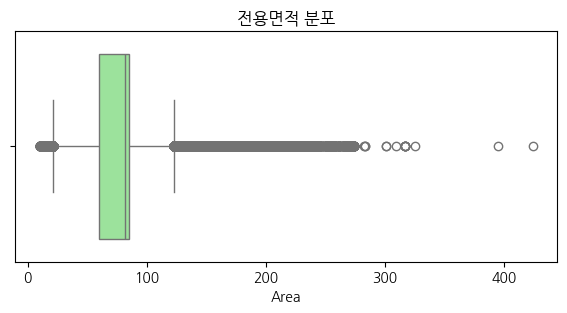

In [45]:
# 대표적인 연속형 변수인 “전용 면적” 변수 관련한 분포를 먼저 살펴보도록 하겠습니다.
fig = plt.figure(figsize=(7, 3))
sns.boxplot(data = concat_select, x = '전용면적', color='lightgreen')
plt.title('전용면적 분포')
plt.xlabel('Area')
plt.show()

In [46]:
# 이상치 제거 방법에는 IQR을 이용하겠습니다.
def remove_outliers_iqr(dt, column_name):
    df = dt.query('is_test == 0')       # train data 내에 있는 이상치만 제거하도록 하겠습니다.
    df_test = dt.query('is_test == 1')

    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 3.0 * IQR
    upper_bound = Q3 + 3.0 * IQR

    df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    result = pd.concat([df, df_test])   # test data와 다시 합쳐주겠습니다.
    return result

In [47]:
# 위 방법으로 전용 면적에 대한 이상치를 제거해보겠습니다.
concat_select = remove_outliers_iqr(concat_select, '전용면적')

In [48]:
# 이상치 제거 후의 shape은 아래와 같습니다. 약 10만개의 데이터가 제거된 모습을 확인할 수 있습니다.
print(concat_select.shape)

(1109290, 12)


In [50]:
concat_select['is_test'].value_counts()     # 또한, train data만 제거되었습니다.

,count
is_test,
0,1100018
1,9272


In [51]:
concat_select.isnull().sum()

,0
시군구,0
아파트명,0
전용면적,0
계약년월,0
계약일,0
층,0
건축년도,0
도로명,0
target,0
is_test,0


## 4. Feature Engineering
- 이제 파생변수를 만들어보도록 하겠습니다.
- 파생 변수는 도메인 지식에 기반해 제작하는 것이 중요합니다.
- 주택의 가격을 예측하는 문제이기 때문에 약간의 부동산 지식을 기반으로 파생 변수를 만들어 보도록 하겠습니다.

In [52]:
# 시군구, 년월 등 분할할 수 있는 변수들은 세부사항 고려를 용이하게 하기 위해 모두 분할해 주겠습니다.
concat_select['구'] = concat_select['시군구'].map(lambda x : x.split()[1])
concat_select['동'] = concat_select['시군구'].map(lambda x : x.split()[2])
del concat_select['시군구']

concat_select['계약년'] = concat_select['계약년월'].astype('str').map(lambda x : x[:4])
concat_select['계약월'] = concat_select['계약년월'].astype('str').map(lambda x : x[4:])

concat_select['date'] = (concat_select['계약년월'].astype(str) + concat_select['계약일'].astype(str).str.zfill(2)).astype(int)
del concat_select['계약년월']

In [53]:
concat_select.columns

Index(['아파트명', '전용면적', '계약일', '층', '건축년도', '도로명', 'target', 'is_test', '좌표X',
       '좌표Y', '구', '동', '계약년', '계약월', 'date'],
      dtype='object')

- 서울의 집값은 강남, 강북 여부에 따라 차이가 많이 난다는 사실은 많이 알려진 사실입니다.
- 따라서 강남/강북의 여부에 따라 파생변수를 생성해주도록 하겠습니다.

In [54]:
all = list(concat_select['구'].unique())
gangnam = ['강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', '강동구']
gangbuk = [x for x in all if x not in gangnam]

assert len(all) == len(gangnam) + len(gangbuk)       # 알맞게 분리되었는지 체크합니다.

In [55]:
# 강남의 여부를 체크합니다.
is_gangnam = []
for x in concat_select['구'].tolist() :
  if x in gangnam :
    is_gangnam.append(1)
  else :
    is_gangnam.append(0)

# 파생변수를 하나 만릅니다.
concat_select['강남여부'] = is_gangnam

In [56]:
concat_select.columns

Index(['아파트명', '전용면적', '계약일', '층', '건축년도', '도로명', 'target', 'is_test', '좌표X',
       '좌표Y', '구', '동', '계약년', '계약월', 'date', '강남여부'],
      dtype='object')

- 또한 신축인지, 구축인지의 여부도 실거래가에 큰 영향을 줄 수 있습니다.
- 따라서 건축년도에 따라 파생변수를 제작해주도록 하겠습니다.

In [57]:
# 건축년도 분포는 아래와 같습니다. 특히 2005년이 Q3에 해당합니다.
# 2009년 이후에 지어진 건물은 10%정도 되는 것을 확인할 수 있습니다.
concat_select['건축년도'].describe(percentiles = [0.1, 0.25, 0.5, 0.75, 0.8, 0.9])

,건축년도
count,1.109290e+06
mean,1.998770e+03
std,9.339225e+00
min,1.961000e+03
10%,1.986000e+03
25%,1.992000e+03
50%,2.000000e+03
75%,2.005000e+03
80%,2.006000e+03
90%,2.010000e+03


In [58]:
# 따라서 2009년 이후에 지어졌으면 비교적 신축이라고 판단하고, 신축 여부 변수를 제작해보도록 하겠습니다.
concat_select['신축여부'] = concat_select['건축년도'].apply(lambda x: 1 if x >= 2009 else 0)

In [59]:
concat_select.head(1)       # 최종 데이터셋은 아래와 같습니다.

,아파트명,전용면적,계약일,층,건축년도,도로명,target,is_test,좌표X,좌표Y,구,동,계약년,계약월,date,강남여부,신축여부
0,개포6차우성,79.97,8,3,1987,언주로 3,124000.0,0,127.05721,37.476763,강남구,개포동,2017,12,20171208,1,0


In [60]:
concat_select.shape

(1109290, 17)

- 위 두 사항 외에도 외부 공공 데이터를 이용하거나, EDA를 통해 더 많은 변수를 제작할 수 있습니다.

## 5. Model Training

- 이제 위에서 만든 파생변수들과 정제한 데이터를 기반으로 본격적으로 부동산 실거래가를 예측하는 모델링을 진행하겠습니다.
- 모델링에는 `sklearn`의 `RandomForest`를 이용하도록 하겠습니다.

- 참고 ✅
  - `RandomForest`는 배깅(Bagging)의 일종으로, 학습시키는 데이터 뿐 아니라 특성변수(X)들도 무작위로 선택해 트리를 생성하는 방법입니다.
  - 모델 학습 과정에서 서로 다른 N개의 Tree 생성하고, N개의 Tree에서 발생한 Output을 Voting(범주형, 분류문제)하거나, Average(연속형, 회귀문제)해 최종 Output 생성합니다.
  - 이는 High variance, Low bias 상황에서 분산(Variance) 감소에 도움을 줍니다.

In [61]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
dt_train = concat_select.query('is_test==0')
dt_test = concat_select.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(1100018, 16) (9272, 16)


In [62]:
dt_test.head(1)

,아파트명,전용면적,계약일,층,건축년도,도로명,target,좌표X,좌표Y,구,동,계약년,계약월,date,강남여부,신축여부
1118822,개포6차우성,79.97,26,5,1987,언주로 3,13250.0,127.05721,37.476763,강남구,개포동,2023,07,20230726,1,0


In [63]:
# dt_test의 target은 일단 0으로 임의로 채워주도록 하겠습니다.
dt_test['target'] = 0

### 5.1. 범주형 변수 Encoding
- 범주형 변수는 그대로 모델에 투입하면, 모델이 제대로 작동할 수 없습니다.
- 따라서 **레이블 인코딩 과정**을 통해 범주형 변수들을 numeric하게 바꾸는 인코딩 과정을 진행해주도록 하겠습니다.

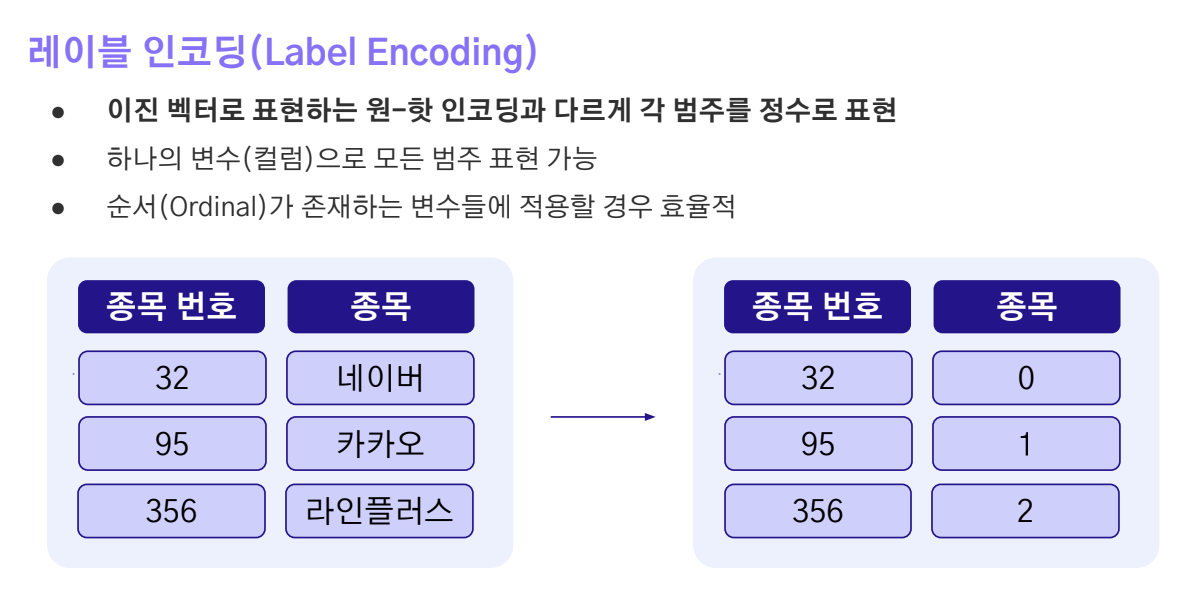

In [64]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['전용면적', '계약일', '층', '건축년도', 'target', '좌표X', '좌표Y', 'date', '강남여부', '신축여부']
범주형 변수: ['아파트명', '도로명', '구', '동', '계약년', '계약월']


In [65]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( dt_train[col].astype(str) )
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(dt_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    dt_test[col] = lbl.transform(dt_test[col].astype(str))

100%|██████████| 6/6 [00:02<00:00,  2.34it/s]


In [66]:
dt_train.head(1)        # 레이블인코딩이 된 모습입니다.

,아파트명,전용면적,계약일,층,건축년도,도로명,target,좌표X,좌표Y,구,동,계약년,계약월,date,강남여부,신축여부
0,320,79.97,8,3,1987,5854,124000.0,127.05721,37.476763,0,8,10,11,20171208,1,0


### 5.2. Model Training
- 위 데이터를 이용해 모델을 train 해보겠습니다. 모델은 RandomForest를 이용하겠습니다.
- Train과 Valid dataset을 분할하는 과정에서는 `holdout` 방법을 사용하겠습니다. 이 방법의 경우  대략적인 성능을 빠르게 확인할 수 있다는 점에서 baseline에서 사용해보도록 하겠습니다.
  - 이 후 추가적인 eda를 통해서 평가세트와 경향을 맞추거나 kfold와 같은 분포에 대한 고려를 추가할 수 있습니다.

In [67]:
assert dt_train.shape[1] == dt_test.shape[1]          # train/test dataset의 shape이 같은지 확인해주겠습니다.

In [68]:
from sklearn.model_selection import KFold

def train_valid_split(data_x, data_y, train_idx, valid_idx):
    x_train = data_x.iloc[train_idx]
    y_train = data_y[train_idx]
    x_valid = data_x.iloc[valid_idx]
    y_valid = data_y[valid_idx]
    return x_train, y_train, x_valid, y_valid

# k-fold cross-validation을 통한 모델 평가 함수
def evaluate(data_x, data_y, model, random_state=42, n_splits=5, test_x=None):
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)

    oof_y = np.zeros(len(data_x))
    feature_importances = np.zeros((len(data_x.columns), n_splits))

    if test_x is not None:
        test_y = np.zeros((len(test_x), n_splits))

    for i, (train_index, valid_index) in enumerate(kf.split(data_x, data_y)):
        train_x, train_y, valid_x, valid_y = train_valid_split(data_x, data_y, train_index, valid_index)
        model.fit(train_x, train_y)

        oof_y[valid_index] = model.predict(valid_x) # out-of-fold 예측값
        feature_importances[:, i] = model.feature_importances_

        if test_x is not None:
            test_y[:, i] = model.predict(test_x)

        print(f'{i}th-fold Validation Score : ', mean_squared_error(valid_y, oof_y[valid_index], squared=False))

    # out-of-fold 예측값에 대한 RMSE score 계산
    score = mean_squared_error(data_y, oof_y, squared=False)
    print('OOF RMSE Score : ', score)

    return (oof_y, np.mean(test_y, axis=1), np.mean(feature_importances, axis=1)) if test_x is not None else (oof_y, np.mean(feature_importances, axis=1))

In [69]:
# lightgbm 설치
!pip install lightgbm==4.0.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 47.6 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.5.0
    Uninstalling lightgbm-4.5.0:
      Successfully uninstalled lightgbm-4.5.0


In [70]:
from lightgbm import LGBMRegressor

# Target과 독립변수들을 분리해줍니다.
X_train_all = dt_train.drop(['target', 'date'], axis=1)
y_train_all = dt_train['target']

# Custom validation split - 최근 20% 데이터를 validation set으로 나눔
dt_train = dt_train.sort_values('date')
cut = int(len(dt_train)*0.8)
train_split = dt_train[:cut]
valid_split = dt_train[cut:]

X_train = train_split.drop(['target', 'date'], axis=1)
y_train = train_split['target']
X_val = valid_split.drop(['target', 'date'], axis=1)
y_val = valid_split['target']

# LGBM 파라미터 설정
lgb_params = {
            'n_estimators': 2048,
            'force_col_wise': True
            }

model = LGBMRegressor(**lgb_params)

In [71]:
# 모델 훈련 및 평가 후 oof 예측값 가져오기
# oof_pred, feature_importances = evaluate(X_train.copy(), y_train.copy(), model)

# 모델 학습 및 평가
model.fit(X_train, y_train)
pred = model.predict(X_val)

# 회귀 관련 metric을 통해 train/valid의 모델 적합 결과를 관찰합니다.
print(f'Validation RMSE: {mean_squared_error(y_val, pred, squared=False)}')

[LightGBM] [Info] Total Bins 1689
[LightGBM] [Info] Number of data points in the train set: 880014, number of used features: 14
[LightGBM] [Info] Start training from score 47856.013045
Validation RMSE: 27240.915256872035


- 변수 중요도도 확인해보도록 하겠습니다.

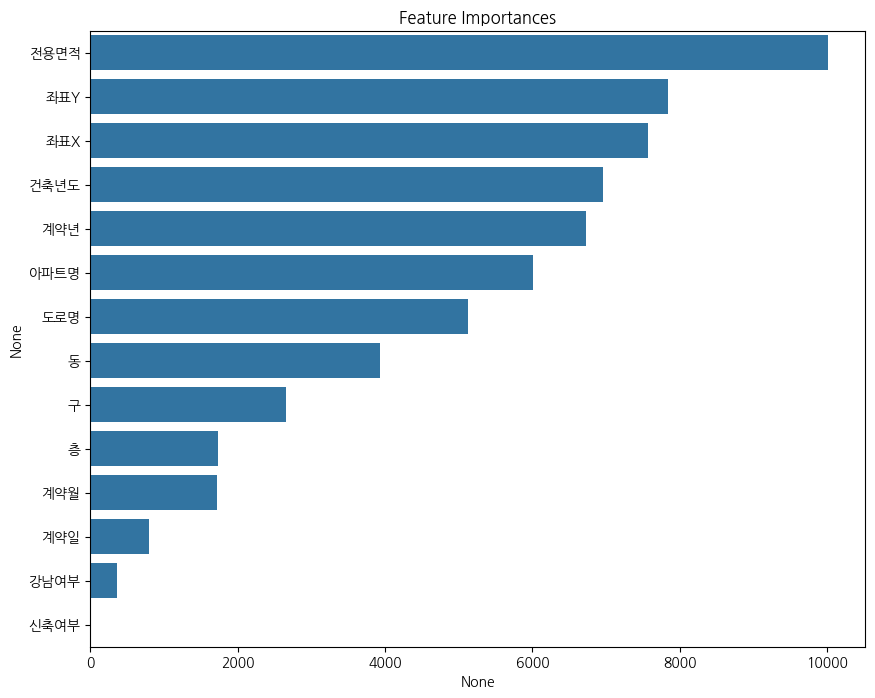

In [72]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [73]:
# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('lightgbm.pkl', 'wb') as f:
    pickle.dump(model, f)

### 5.3. Feature selection

- 어떤 변수가 유용한 변수인지 확인해보기 위해 permutation selection을 이용해보겠습니다.

In [74]:
# Permutation importance 방법을 변수 선택에 이용해보겠습니다.
perm = PermutationImportance(model,        # 위에서 학습된 모델을 이용하겠습니다.
                             scoring = "neg_mean_squared_error",        # 평가 지표로는 회귀문제이기에 negative rmse를 사용합니다. (neg_mean_squared_error : 음의 평균 제곱 오차)
                             random_state = 42,
                             n_iter=3).fit(X_val, y_val)
eli5.show_weights(perm, feature_names = X_val.columns.tolist())    # valid data에 대해 적합시킵니다.

Weight,Feature
1357089741.0284 ± 6299584.6310,전용면적
880090149.9134 ± 4856737.8362,좌표Y
636742696.3065 ± 725731.5358,건축년도
628751696.7118 ± 10314908.6213,좌표X
453754581.4886 ± 3150455.9577,구
212686532.0083 ± 3671642.2293,강남여부
166473867.5589 ± 1021306.8528,아파트명
166378205.7139 ± 565141.8263,도로명
163108808.5854 ± 923877.0368,동
43353844.5241 ± 951068.9937,층


- 분석 결과 "계약년", "전용면적" 변수가 유의한 변수로 보입니다. 따라서 이 변수로 또 다른 파생변수를 더 생성해보거나, 중요도가 낮아보이는 변수를 제거해 차원의 저주를 막아볼 수도 있습니다.

### 5.4. Valid prediction 분석

- 예측값을 분석해보기 위해 valid prediction을 확인해보겠습니다.

In [76]:
# Validation dataset에 target과 pred 값을 채워주도록 하겠습니다.
X_val['target'] = y_val
X_val['pred'] = pred

In [77]:
# Squared_error를 계산하는 함수를 정의하겠습니다.
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

# RMSE 계산
squared_errors = calculate_se(X_val['target'], X_val['pred'])
X_val['error'] = squared_errors

In [78]:
# Error가 큰 순서대로 sorting 해 보겠습니다.
X_val_sort = X_val.sort_values(by='error', ascending=False)       # 내림차순 sorting

In [79]:
X_val_sort.head()

,아파트명,전용면적,계약일,층,건축년도,도로명,좌표X,좌표Y,구,동,계약년,계약월,강남여부,신축여부,target,pred,error
216385,3859,159.6030,19,45,2020,6502,127.043853,37.544798,15,158,16,3,0,1,675000.0,282083.395680,1.543835e+11
216384,3859,159.6030,26,27,2020,6502,127.043853,37.544798,15,158,16,2,0,1,620000.0,279898.869768,1.156688e+11
223562,1577,131.3226,22,8,2019,4209,127.066481,37.485247,0,8,15,1,1,1,590000.0,254266.059800,1.127173e+11
232708,5438,152.1556,14,13,2017,6493,127.044437,37.538534,15,158,15,5,0,1,640000.0,309734.739953,1.090751e+11
232709,5438,152.1556,14,13,2017,6493,127.044437,37.538534,15,158,15,5,0,1,640000.0,309734.739953,1.090751e+11


- 예측을 잘 하지 못한 top 100개의 데이터와 예측을 잘한 top 100개의 데이터를 비교해보겠습니다.

In [80]:
X_val_sort_top100 = X_val.sort_values(by='error', ascending=False).head(100)        # 예측을 잘 하지못한 top 100개의 data
X_val_sort_tail100 = X_val.sort_values(by='error', ascending=False).tail(100)       # 예측을 잘한 top 100개의 data

In [81]:
# 해석을 위해 레이블인코딩 된 변수를 복원해줍니다.
error_top100 = X_val_sort_top100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    error_top100[column] = label_encoders[column].inverse_transform(X_val_sort_top100[column])

best_top100 = X_val_sort_tail100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    best_top100[column] = label_encoders[column].inverse_transform(X_val_sort_tail100[column])

In [82]:
display(error_top100.head(1))
display(best_top100.head(1))

,아파트명,전용면적,계약일,층,건축년도,도로명,좌표X,좌표Y,구,동,계약년,계약월,강남여부,신축여부,target,pred,error
216385,아크로서울포레스트,159.603,19,45,2020,왕십리로 83-21,127.043853,37.544798,성동구,성수동1가,2023,04,0,1,675000.0,282083.39568,1.543835e+11


,아파트명,전용면적,계약일,층,건축년도,도로명,좌표X,좌표Y,구,동,계약년,계약월,강남여부,신축여부,target,pred,error
400219,삼성한사랑1,59.73,1,4,1997,양천로66길 6,126.863892,37.555204,강서구,등촌동,2019,05,1,0,44500.0,44507.963091,63.410816


- 이제 분포를 비교해보도록 하겠습니다.

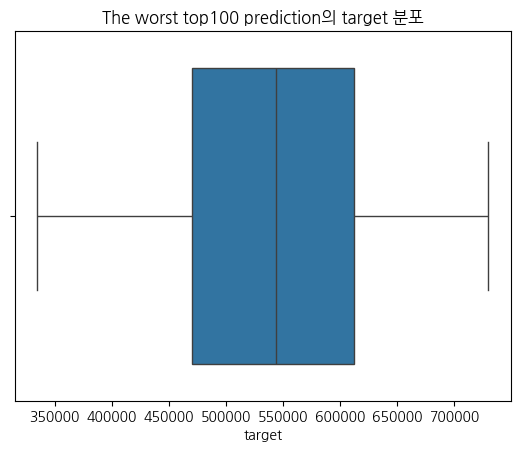

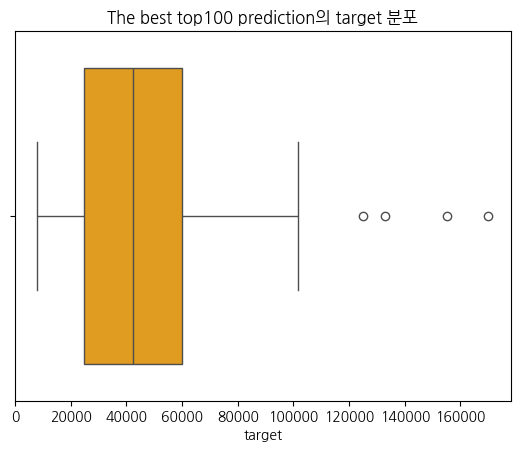

In [83]:
sns.boxplot(data = error_top100, x='target')
plt.title('The worst top100 prediction의 target 분포')
plt.show()

sns.boxplot(data = best_top100, x='target', color='orange')
plt.title('The best top100 prediction의 target 분포')
plt.show()

- Taget 분포를 보니 좋은 예측을 보인 top 100개의 data보다 상대적으로 나쁜 예측을 보인 top 100 dataset들이 높은 가격을 보였음을 확인할 수 있습니다. 이에 대한 모델링 및 처리가 필요해보입니다.

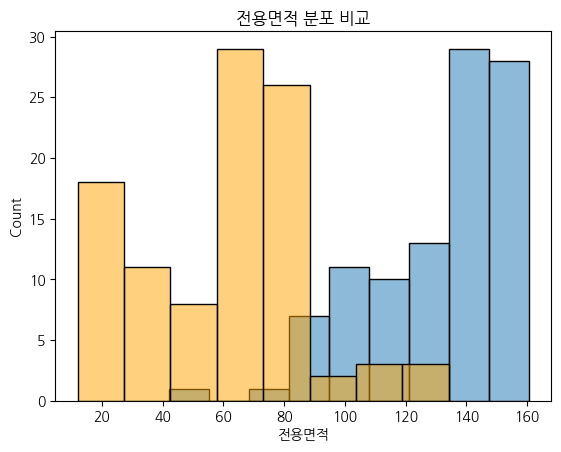

In [84]:
sns.histplot(data = error_top100, x='전용면적', alpha=0.5)
sns.histplot(data = best_top100, x='전용면적', color='orange', alpha=0.5)
plt.title('전용면적 분포 비교')
plt.show()

- 전용면적 또한 나쁜 예측을 보인 집들이 더 넓음을 확인할 수 있습니다.

## 6. Inference

In [85]:
dt_test.head(2)      # test dataset에 대한 inference를 진행해보겠습니다.

,아파트명,전용면적,계약일,층,건축년도,도로명,target,좌표X,좌표Y,구,동,계약년,계약월,date,강남여부,신축여부
1118822,320,79.9700,26,5,1987,5854,0,127.057210,37.476763,0,8,16,6,20230726,1,0
1118823,321,108.2017,15,10,2021,431,0,127.056394,37.484892,0,8,16,7,20230815,1,1


In [86]:
# 저장된 모델을 불러옵니다.
with open('lightgbm.pkl', 'rb') as f:
    model = pickle.load(f)

In [87]:
%%time
X_test = dt_test.drop(['target','date'], axis=1)

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = model.predict(X_test)

CPU times: user 1.5 s, sys: 1.9 ms, total: 1.5 s
Wall time: 1.52 s


In [88]:
real_test_pred          # 예측값들이 출력됨을 확인할 수 있습니다.

array([148795.04781212, 208263.01273352, 241140.50019636, ...,
        63883.43242951,  62538.050105  ,  59953.49437638])

## 7. Output File Save

In [89]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)
